In [1]:
import torch


def load_image(file):
    import PIL.Image
    import numpy as np

    image = PIL.Image.open('./datas/%s' % file)
    image = image.resize((512, 512))
    image = np.array(image, dtype=np.float32)
    image = (image - 127.5) / 127.5
    image = image.transpose(2, 0, 1)[np.newaxis, :]

    image = torch.FloatTensor(image)

    return image


image_content = load_image('content.jpeg')
image_style = load_image('style.jpg')

image_content.shape, image_style.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

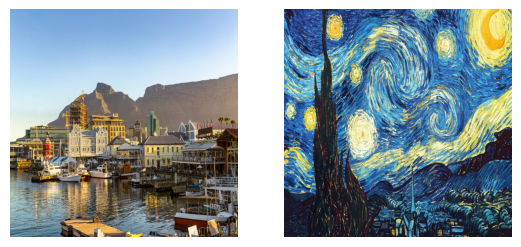

In [2]:
def show(images):
    from matplotlib import pyplot as plt

    for i in range(len(images)):
        image = images[i]
        if type(image) == torch.Tensor:
            image = image.to('cpu').detach().numpy()
            images[i] = image

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i][0]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show([image_content, image_style])

In [3]:
import torchvision

vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1').features[:29]

vgg19.eval()
for param in vgg19.parameters():
    param.requires_grad_(False)


def get_feature(image):
    feature = []
    for i, layer in enumerate(vgg19):
        image = layer(image)
        if i in [0, 5, 10, 19, 28]:
            feature.append(image)

    return feature


for i in get_feature(torch.randn(1, 3, 512, 512)):
    print(i.shape)

torch.Size([1, 64, 512, 512])
torch.Size([1, 128, 256, 256])
torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 32, 32])


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg19.to(device)

image_content = image_content.to(device)
image_style = image_style.to(device)

image_gen = image_content.clone().to(device)
image_gen.requires_grad = True
optimizer = torch.optim.Adam([image_gen], lr=4e-3)

device

'cuda'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 39200079872.0


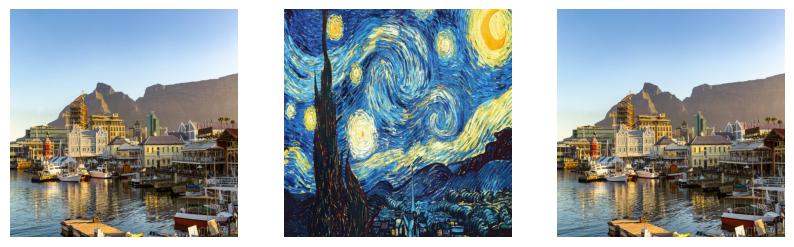

/root/anaconda3/envs/pt39/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [1, 3, 512, 512], strides() = [0, 1, 1536, 3]
param.sizes() = [1, 3, 512, 512], strides() = [0, 1, 1536, 3] (Triggered internally at  ../torch/csrc/autograd/functions/accumulate_grad.h:193.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000 79755992.0


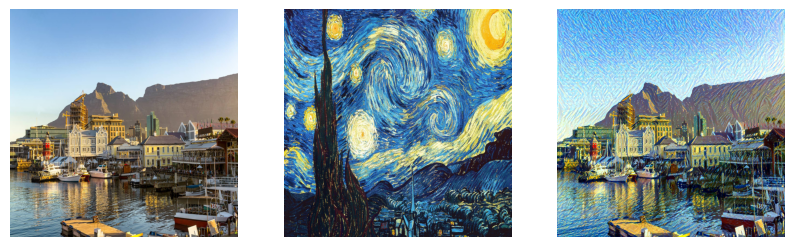

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2000 36590344.0


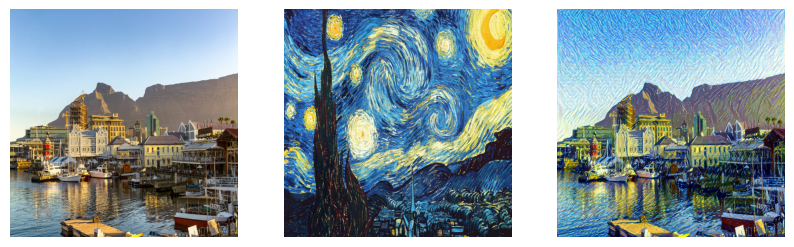

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3000 20372314.0


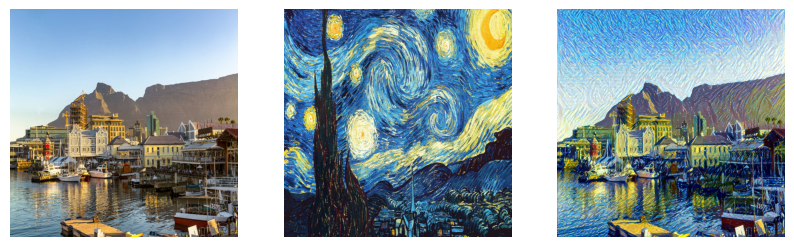

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4000 12761818.0


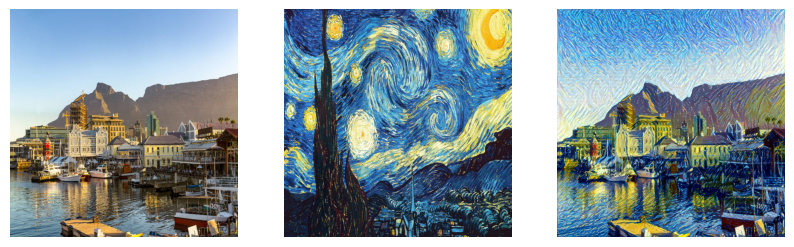

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5000 8408491.0


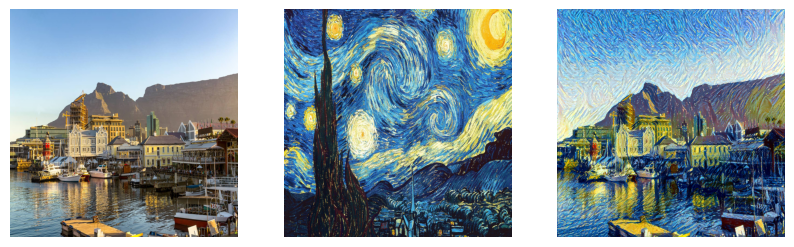

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6000 5811863.0


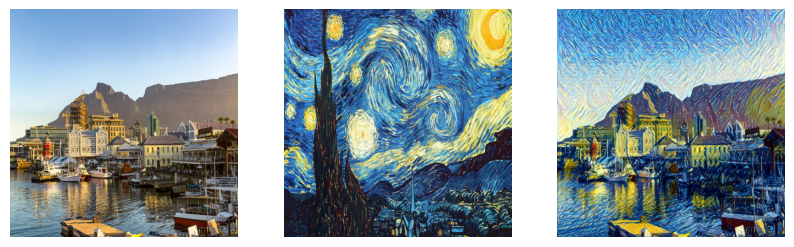

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7000 5068461.0


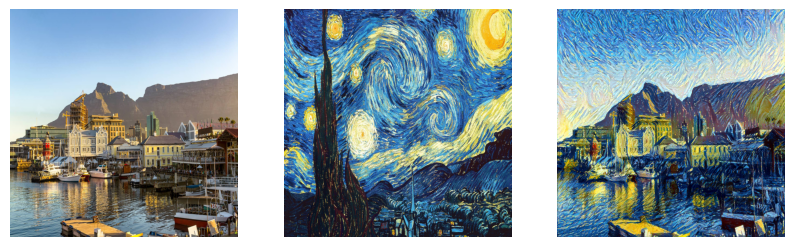

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8000 3759491.75


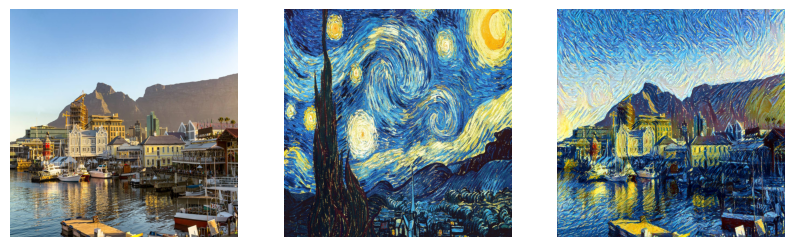

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9000 2828985.5


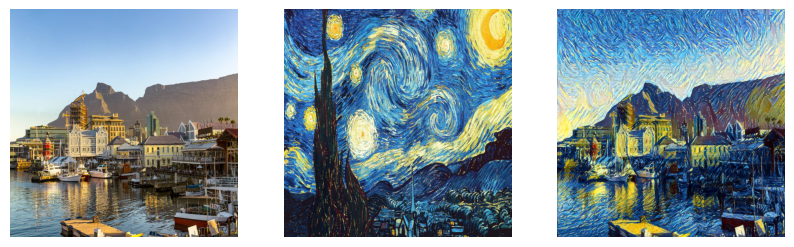

In [5]:
def train():
    for epoch in range(10000):
        feature_gen = get_feature(image_gen)
        feature_content = get_feature(image_content)
        feature_style = get_feature(image_style)

        loss_style_sum = 0
        loss_content_sum = 0
        for i in range(5):
            loss_content = feature_gen[i] - feature_content[i]
            loss_content = loss_content.pow(2).mean()
            loss_content_sum += loss_content

            #[1, c, h, w] -> [c, h*w]
            feature_gen_i = feature_gen[i].flatten(start_dim=2).squeeze(dim=0)
            #[c, h*w] * [h*w, c] -> [c, c]
            feature_gen_i = feature_gen_i.mm(feature_gen_i.t())

            #[1, c, h, w] -> [c, h*w]
            featue_style_i = feature_style[i].flatten(start_dim=2).squeeze(
                dim=0)
            #[c, h*w] * [h*w, c] -> [c, c]
            featue_style_i = featue_style_i.mm(featue_style_i.t())

            loss_style = feature_gen_i - featue_style_i
            loss_style = loss_style.pow(2).mean()

            loss_style_sum += loss_style

        loss = loss_content_sum + loss_style_sum * 10

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 1000 == 0:
            print(epoch, loss.item())
            show([image_content, image_style, image_gen])


train()